Based on yesterday's call, here's what I'm thinking in terms of methodology:

- do topic modeling of source code identifiers from all flaky tests from all n projects, and on all flaky tests from a random subset of n/2 projects. Check if we're losing any potentially interesting topics by limiting it to n/2 projects -- hopefully not. This will give us k topics and a matrix of 'flaky tests x flaky topic'. We can use this matrix to identify each test's dominant topic. This will also help answer an exploratory research question about different kinds of flakiness.
- use machine learning to build one classifier each for each of the k topics, on the same n/2 projects. We'll keep the remaining n/2 projects for validation only. These classifiers will take a test case as input and predict whether it's (a) not flaky or (b) flaky according to a specific kind of flakiness (i.e., topic).
- validate the k classifiers on the remaining n/2 projects. I would suggest we do manual annotation for the flaky tests in this step, to determine for each test what kind of flakiness it is affected by. We can then report the performance of each of the k classifiers in terms of (a) how well it predicted flakiness, and (b) whether it picked up on the right kind of flakiness.

In [1]:
import pandas as pd
import re

In [2]:
data = pd.read_csv('../data/msr/msr_data.csv')
data = data.drop_duplicates()
data.head()

,token,project,flaky
0,call testResourceGetPostParamGet POST MyJsonR...,oozie,1
1,cluster createTable getClusterStatus hcd TEST_...,hadoop,1
2,fail testSetMaxInvalid Assert setDefaultMaxPer...,httpcore,0
3,thinks that it is single rack assertSingleSwi...,hadoop,0
4,hcatUri2 checkCoordAction CoordELFunctions hc...,oozie,1


In [3]:
positive_data = data.query('flaky == 1')
positive_data.shape

(1383, 3)

In [4]:
negative_data = data.query('flaky == 0')
negative_data.shape

(1388, 3)

In [5]:
def preprocess(input_data):
    text_data = pd.DataFrame()
    #do camelcase splitting
    text_data['camel_case_split'] = input_data['token'].astype('U').map(lambda x: re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', x)))
    #lowercase all test cases
    text_data['lowered'] = [token.lower() for token in text_data['camel_case_split'].astype('U')]
    #remove punctuations such as _,/.!?{}=: 
    text_data['no_punctuation'] = text_data['lowered'].map(lambda x: re.sub('[_,/.!?{}=:]', '', x))
    #remove assert* tokens
    text_data['no_assert'] = text_data['no_punctuation'].map(lambda x: re.sub('assert', '', x))
    #remove equals* tokens
    text_data['no_assert_equals'] = text_data['no_assert'].map(lambda x: re.sub('equals', '', x))
    #remove test tokens
    text_data['clean'] = text_data['no_assert_equals'].map(lambda x: re.sub('test', '', x))
    return text_data, text_data['clean']

#sample 50% for training topic modelling model
lda_training_data = positive_data.sample(frac=0.5, random_state=7)
nb_flaky_test_data = positive_data.query(f'index not in {list(lda_training_data.index)}')
lda_processed_data, X_lda = preprocess(lda_training_data)

In [6]:
lda_processed_data.head()

,camel_case_split,lowered,no_punctuation,no_assert,no_assert_equals,clean
621,cluster tries get Name Checked if node was ...,cluster tries get name checked if node was ...,cluster tries get name checked if node was ...,cluster tries get name checked if node was ...,cluster tries get name checked if node was ...,cluster tries get name checked if node was ...
80,FS001 FS002 viewfs is a supported scheme. ...,fs001 fs002 viewfs is a supported scheme. ...,fs001 fs002 viewfs is a supported scheme t...,fs001 fs002 viewfs is a supported scheme t...,fs001 fs002 viewfs is a supported scheme t...,fs001 fs002 viewfs is a supported scheme t...
2242,the match calls a player event on it's deacti...,the match calls a player event on it's deacti...,the match calls a player event on it's deacti...,the match calls a player event on it's deacti...,the match calls a player event on it's deacti...,the match calls a player event on it's deacti...
1761,date script Executor session Given insert ...,date script executor session given insert ...,date script executor session given insert ...,date script executor session given insert ...,date script executor session given insert ...,date script executor session given insert ...
1172,Check for resolved conf test Dry Run Pus...,check for resolved conf test dry run pus...,check for resolved conf test dry run pus...,check for resolved conf test dry run pus...,check for resolved conf test dry run pus...,check for resolved conf dry run push d...


### This LDA implementation is avaiable at 
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

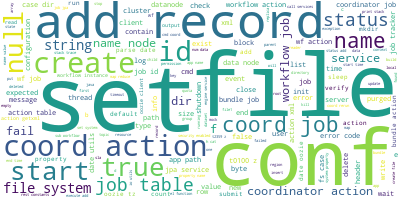

In [7]:
#view most frequent words
from wordcloud import WordCloud
long_string = ','.join(X_lda)
word_cloud = WordCloud(background_color="white",
                       max_words=5000, contour_width=3,
                       contour_color='steelblue')

word_cloud.generate(long_string)
word_cloud.to_image()

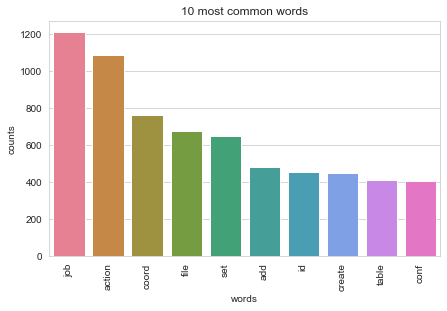

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(7, 7/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
    
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(X_lda)
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [9]:
import gensim
from gensim.utils import simple_preprocess

#transforms sentences to individual words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = X_lda.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:5])

[['cluster', 'tries', 'get', 'name', 'checked', 'if', 'node', 'was', 'recommissioned', 'conf', 'all', 'datanodes', 'must', 'be', 'alive', 'num', 'namenodes', 'start', 'cluster', 'sleep', 'decommissioned', 'nodes', 'wait', 'for', 'the', 'block', 'to', 'be', 'deleted', 'true', 'times', 'before', 'recommissioned', 'get', 'client', 'num', 'datanodes', 'write', 'file', 'cleanup', 'file', 'info', 'check', 'file', 'add', 'tried', 'get', 'dfs', 'client', 'log', 'datanode', 'report', 'replicas', 'decom', 'node', 'decommission', 'one', 'node', 'verify', 'that', 'node', 'is', 'decommissioned', 'ensure', 'decommissioned', 'datanode', 'is', 'not', 'automatically', 'shutdown', 'get', 'file', 'system', 'recommission', 'get', 'name', 'node', 'thread', 'admin', 'states', 'null', 'recomission', 'node', 'file', 'sys', 'file', 'starting', 'recommission', 'namenode', 'decom', 'list', 'stop', 'decommission', 'and', 'check', 'if', 'the', 'new', 'replicas', 'are', 'removed', 'times', 'decommission', 'node', '

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [11]:
#using java reserved words as stop words
stop_words = ['abstract', 'assert', 'boolean', 'break', 'byte', 'case', 'catch', 'char', 'class', 
              'const', 'continue','default', 'double', 'do', 'else', 'enum', 'extends', 'false', 
              'final', 'finally', 'float', 'for', 'goto', 'if', 'implements', 'import', 'instanceof', 
              'int', 'interface', 'long' ,'native', 'new', 'null', 'package', 'private', 'protected', 
              'public', 'return', 'short', 'static', 'strictfp', 'super', 'switch','synchronized', 
              'this', 'throw', 'throws','transient', 'true', 'try', 'void', 'volatile','while', 'test', 'get', 'set']

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [12]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

print(data_words_bigrams[:1])

[['cluster', 'tries', 'name', 'checked', 'node', 'was', 'recommissioned', 'conf', 'all', 'datanodes', 'must', 'be', 'alive', 'num', 'namenodes', 'start', 'cluster', 'sleep', 'decommissioned', 'nodes', 'wait', 'the', 'block', 'to', 'be', 'deleted', 'times', 'before', 'recommissioned', 'client', 'num', 'datanodes', 'write', 'file', 'cleanup', 'file', 'info', 'check', 'file', 'add', 'tried', 'dfs', 'client', 'log', 'datanode_report', 'replicas', 'decom', 'node', 'decommission', 'one', 'node', 'verify', 'that', 'node', 'is', 'decommissioned', 'ensure', 'decommissioned', 'datanode', 'is', 'not', 'automatically', 'shutdown', 'file', 'system', 'recommission', 'name', 'node', 'thread', 'admin', 'states', 'recomission', 'node', 'file', 'sys', 'file', 'starting', 'recommission', 'namenode', 'decom', 'list', 'stop', 'decommission', 'and', 'check', 'the', 'replicas', 'are', 'removed', 'times', 'decommission', 'node', 'shutdown', 'decommissiondat', 'datanode_report', 'type']]


In [13]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:5])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 2), (14, 2), (15, 1), (16, 1), (17, 2), (18, 2), (19, 2), (20, 3), (21, 1), (22, 3), (23, 1), (24, 1), (25, 1), (26, 6), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 7), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 2), (42, 2), (43, 1), (44, 2), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 2), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1)], [(26, 1), (28, 2), (37, 2), (52, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 2), (84, 1), (85, 2), (86, 1), (87, 1), (88, 1), (89, 2), (90, 3), (91, 2), (92, 1), (93, 1)], [(0, 1), (12, 1), (13, 2), (37, 1), (54, 3), (57, 2), (94, 1), (95, 1), (96, 1), (97, 1), (98, 2), (99, 2), (100, 3), (101,

In [14]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=4, 
                                       random_state=100,
                                       chunksize=5000,
                                       passes=10,
                                       per_word_topics=True)

In [15]:
from pprint import pprint

# prints most relevant keywords with its weigh for each topic
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.028*"name" + 0.024*"job" + 0.022*"app" + 0.017*"conf" + 0.014*"user" + '
  '0.013*"create" + 0.013*"property" + 0.013*"oozie" + 0.012*"value" + '
  '0.011*"workflow"'),
 (1,
  '0.028*"job" + 0.028*"id" + 0.024*"to" + 0.020*"coord" + 0.015*"status" + '
  '0.015*"table" + 0.013*"action" + 0.013*"date" + 0.012*"execute" + '
  '0.012*"add"'),
 (2,
  '0.075*"action" + 0.055*"job" + 0.038*"coord" + 0.022*"wf" + 0.021*"to" + '
  '0.020*"add" + 0.019*"should" + 0.019*"workflow" + 0.017*"table" + '
  '0.016*"not"'),
 (3,
  '0.045*"file" + 0.022*"the" + 0.014*"to" + 0.014*"create" + 0.012*"block" + '
  '0.011*"system" + 0.010*"cluster" + 0.010*"data" + 0.010*"is" + 0.009*"dfs"')]


In [16]:
from gensim.models import CoherenceModel

# Compute Coherence Score (the higher the better)
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5233702548454152


In [17]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics, the higher the coherence more separated the topics will tend to be
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

c:\users\aian\appdata\local\programs\python\python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.142314  0.044784       1        1  30.248442
0      0.047278 -0.156939       2        1  25.546444
3     -0.200006  0.000578       3        1  24.278215
1      0.010414  0.111577       4        1  19.926895, topic_info=    Category         Freq         Term        Total  loglift  logprob
149  Default  1200.000000       action  1200.000000  30.0000  30.0000
174  Default  1228.000000          job  1228.000000  29.0000  29.0000
160  Default   725.000000        coord   725.000000  28.0000  28.0000
26   Default   767.000000         file   767.000000  27.0000  27.0000
279  Default   382.000000           wf   382.000000  26.0000  26.0000
..       ...          ...          ...          ...      ...      ...
149   Topic4   111.710861       action  1200.006348  -0.7611  -4.3435
162   Topic4    63.267513  coordinator   291.038818   0.0870  -4.9121
54    Topic4    66.824982          the   369.886230  -0.0980  -4.8574
132   Topic4    48.059174           of   153.929169   0.4490  -5.1870
148   Topic4    46.527939         with   215.759308   0.0790  -5.2194

[308 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
588       3  0.909130  accept_frame
149       1  0.811662        action
149       2  0.094166        action
149       3  0.000833        action
149       4  0.093333        action
...     ...       ...           ...
197       4  0.012487           xml
705       2  0.973414         xmlns
748       2  0.961126      year_day
976       1  0.929809    year_month
1065      1  0.893897           yes

[553 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

In [18]:
from operator import itemgetter

#associates each test case to its given topic by the model at the ``topic`` column
topics = []
for test_case in corpus:
    prob_distribution = lda_model.get_document_topics(test_case)
    topics.append(max(prob_distribution, key=itemgetter(1))[0])

lda_processed_data['topic'] = topics
lda_processed_data.head()

,camel_case_split,lowered,no_punctuation,no_assert,no_assert_equals,clean,topic
621,cluster tries get Name Checked if node was ...,cluster tries get name checked if node was ...,cluster tries get name checked if node was ...,cluster tries get name checked if node was ...,cluster tries get name checked if node was ...,cluster tries get name checked if node was ...,3
80,FS001 FS002 viewfs is a supported scheme. ...,fs001 fs002 viewfs is a supported scheme. ...,fs001 fs002 viewfs is a supported scheme t...,fs001 fs002 viewfs is a supported scheme t...,fs001 fs002 viewfs is a supported scheme t...,fs001 fs002 viewfs is a supported scheme t...,2
2242,the match calls a player event on it's deacti...,the match calls a player event on it's deacti...,the match calls a player event on it's deacti...,the match calls a player event on it's deacti...,the match calls a player event on it's deacti...,the match calls a player event on it's deacti...,3
1761,date script Executor session Given insert ...,date script executor session given insert ...,date script executor session given insert ...,date script executor session given insert ...,date script executor session given insert ...,date script executor session given insert ...,1
1172,Check for resolved conf test Dry Run Pus...,check for resolved conf test dry run pus...,check for resolved conf test dry run pus...,check for resolved conf test dry run pus...,check for resolved conf test dry run pus...,check for resolved conf dry run push d...,2


In [19]:
#view the proportion of each topic
lda_processed_data['topic'].value_counts(normalize=True)

0    0.271676
3    0.257225
2    0.257225
1    0.213873
Name: topic, dtype: float64

In [20]:
#topics were assigned from 0 to 4, this part changes to 1 to 5, 0 now will indicate non flakiness

lda_processed_data['flaky'] = [topic + 1 for topic in topics]
lda_processed_data.head()

,camel_case_split,lowered,no_punctuation,no_assert,no_assert_equals,clean,topic,flaky
621,cluster tries get Name Checked if node was ...,cluster tries get name checked if node was ...,cluster tries get name checked if node was ...,cluster tries get name checked if node was ...,cluster tries get name checked if node was ...,cluster tries get name checked if node was ...,3,4
80,FS001 FS002 viewfs is a supported scheme. ...,fs001 fs002 viewfs is a supported scheme. ...,fs001 fs002 viewfs is a supported scheme t...,fs001 fs002 viewfs is a supported scheme t...,fs001 fs002 viewfs is a supported scheme t...,fs001 fs002 viewfs is a supported scheme t...,2,3
2242,the match calls a player event on it's deacti...,the match calls a player event on it's deacti...,the match calls a player event on it's deacti...,the match calls a player event on it's deacti...,the match calls a player event on it's deacti...,the match calls a player event on it's deacti...,3,4
1761,date script Executor session Given insert ...,date script executor session given insert ...,date script executor session given insert ...,date script executor session given insert ...,date script executor session given insert ...,date script executor session given insert ...,1,2
1172,Check for resolved conf test Dry Run Pus...,check for resolved conf test dry run pus...,check for resolved conf test dry run pus...,check for resolved conf test dry run pus...,check for resolved conf test dry run pus...,check for resolved conf dry run push d...,2,3


Now the data is ready to train the classificator, in this case, MultinomialNB, the classifier will learn to assign topics from 0 to 5 for new unseen data.

The data is splitted as follows:

![data split](./data_split.png)


In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split

#train data
nb_pos_train_data = lda_processed_data.drop(columns='topic')
nb_neg_train_data_sample = negative_data.sample(n=len(lda_processed_data), random_state=7)
nb_neg_train_data, _ = preprocess(nb_neg_train_data_sample)
nb_neg_train_data['flaky'] = 0
nb_train_data = nb_pos_train_data.append(nb_neg_train_data)
nb_train_data_shuffled = nb_train_data.sample(frac=1, random_state=7)

X_train = nb_train_data_shuffled['clean']
y_train = nb_train_data_shuffled['flaky']

#test_data
nb_pos_test_data, _ = preprocess(nb_flaky_test_data)
nb_pos_test_data['flaky'] = 1
nb_neg_test_data_sample = negative_data.query(f'index not in {list(nb_neg_train_data_sample.index)}')
nb_neg_test_data, _ = preprocess(nb_neg_test_data_sample)
nb_neg_test_data['flaky'] = 0
nb_test_data = nb_pos_test_data.append(nb_neg_test_data)
nb_test_data_shuffled = nb_test_data.sample(frac=1, random_state=11)

X_test = nb_test_data_shuffled['clean']
y_test = nb_test_data_shuffled['flaky']

text_clf = Pipeline([('vectorizer', CountVectorizer()),
                     ('model', MultinomialNB())])
text_clf.fit(X_train, y_train)
preds = text_clf.predict(X_test)

For the evaluation of the model, the accuracy is used, but, as we dont't have the ground truth topic of each test case, any positive topic will be converted to 1 in the cell below.

In [22]:
predictions = [1 if value > 0 else 0 for value in preds]
acc = sum(predictions & nb_test_data_shuffled['flaky'])/len(nb_test_data_shuffled)
print('accuracy', acc)

accuracy 0.4426820475847152


## In this part, another kind of LDA is tested, the tutorial is avaiable at 
https://thinkinfi.com/guide-to-build-best-lda-model-using-gensim-python/

Make sure you have java installed and adjust to the correct path

In [31]:
import os
import time
     
os.environ.update({'MALLET_HOME':r'C:/Users/Aian/Documents/college/research/flaky-tests/topic-modelling/mallet-2.0.8'})
mallet_path = 'C:/Users/Aian/Documents/college/research/flaky-tests/topic-modelling/mallet-2.0.8/bin/mallet'

start_time = time.time()

## Train LDA with mallet
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                              corpus=corpus,
                                              id2word=id2word,
                                              num_topics=4)

## Print time taken to train the model
print("--- %s seconds ---" % (time.time() - start_time))

--- 49.80779576301575 seconds ---


In [28]:
# Compute Coherence Score for mallet
coherence_model_lda = gensim.models.CoherenceModel(model=lda_mallet, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('nCoherence Score: ', coherence_lda)

nCoherence Score:  0.5335603578510384
